In [1]:
#from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
#from mnist_cnn.mnistDatasetLoader import MnistDatasetLoader
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.nn import dilation2d
from tensorflow.nn import erosion2d
from tensorflow.nn import conv2d

In [2]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
#img_data = (img_data - 127.5) / 127.5
print(img_data.shape)

(60000, 28, 28, 1)


In [3]:
def histogram(img):
    width = img.shape[0]
    height = img.shape[1]
    histogram = np.zeros([256], np.int32)
    for i in range(width):
        for j in range(height):
            histogram[img[i,j]] += 1
    return histogram

In [4]:
def mean_gray_level(hist): #same as np.mean()
    sum = 0
    for i in range(hist.shape[0]):
        sum += (i*hist[i])
    return sum / hist.sum()

In [5]:
def second_moment(hist): #E(X^2)
    sum = 0
    for i in range(hist.shape[0]):
        sum += (i*i*hist[i])
    return sum / hist.sum()
#var would be E((X-mu)^2)

In [6]:
def opening(img, structuring_element):
    erosion = erosion2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = dilation2d(erosion, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

def closing(img, structuring_element):
    dilation = dilation2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = erosion2d(dilation, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

#open-close-close-open
def occo(img, structuring_element):
    op = opening(img, structuring_element)
    open_close = closing(op, structuring_element)
    cl = closing(img, structuring_element)
    close_open = opening(cl, structuring_element)
    return (open_close + close_open)/2

In [7]:
# compute the binary map of an image
# if the gray-level of a pixel is below the threshold it becomes 0, otherwise 1
# using the square-root of the second moment of the image as a threshold
def computeBinaryMap(img):
    width = img.shape[0]
    height = img.shape[1]
    threshold = math.sqrt(second_moment(histogram(img)))
    newImg = np.zeros([width, height], np.int32)
    for i in range(width):
        for j in range(height):
            if(img[i,j] < threshold):
                newImg[i,j] = 0
            else:
                newImg[i,j] = 1
    return newImg

In [8]:
# compute U by counting the edges between 0s and 1s in the binary map
# done with a conv2D
def computeU(binMap):
    kernel1 = np.array([[-1,1]], np.int32)
    kernel1 = np.expand_dims(kernel1, -1)
    kernel1 = np.expand_dims(kernel1, -1)
    #print(kernel1.shape)
    kernel2 = np.array([[-1],[1]], np.int32)
    kernel2 = np.expand_dims(kernel2, -1)
    kernel2 = np.expand_dims(kernel2, -1)
    #print(kernel2.shape)
    horizU = conv2d(binMap, kernel1, strides = (1,1,1,1), padding = 'VALID')
    vertU = conv2d(binMap, kernel2, strides = (1,1,1,1), padding = 'VALID')
    horizU = tf.abs(horizU)
    vertU = tf.abs(vertU)
    hSum = tf.reduce_sum(horizU)
    vSum = tf.reduce_sum(vertU)
    return hSum + vSum

In [9]:
image = img_data[0]
hist = histogram(image)
meanVal = mean_gray_level(hist)
secondMoment = second_moment(hist)
print(meanVal)
print(secondMoment)

35.108418367346935
7576.536989795918


In [10]:
print(np.mean(image))
print(np.sum(image)/784)
print(np.var(image))

35.108418367346935
35.108418367346935
6343.935949539255


In [11]:
dim = img_data.shape[0]
whitespaces = np.zeros([dim], np.int32)
unglaette = np.zeros([dim], np.int32)
for i in range(dim):
    whitespaces[i] = np.sum(img_data[i])
    binaryImg = computeBinaryMap(img_data[i])
    binaryImg_ = np.expand_dims(np.expand_dims(binaryImg, 0), -1)
    unglaette[i] = computeU(binaryImg_)
print(whitespaces[0:10])
print(unglaette[0:10])

[27525 31095 19443 17135 23214 29601 17646 35867 10874 21904]
[114 124 106  64 104 130  52 112  50 106]


In [17]:
def adj_r_squared(x, y, deg):
    n = len(y)
    coeffs = np.polyfit(x, y, deg)
    p = np.poly1d(coeffs)
    y_hat = p(x)
    y_bar = np.mean(y)
    ss_res = np.sum((y-y_hat)**2)
    ss_tot = np.sum((y-y_bar)**2)
    r_squared = 1-(ss_res/ss_tot)
    result = 1 - (1 - r_squared)*((n-1)/(n-deg-1))
    return result

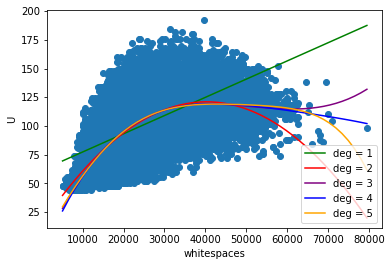

degree = 1, adj_r_squared =  0.35438774835709486
degree = 2, adj_r_squared =  0.4451893034214994
degree = 3, adj_r_squared =  0.45064157706861807
degree = 4, adj_r_squared =  0.4507505309550346
degree = 5, adj_r_squared =  0.4508992749246621


In [37]:
plt.scatter(x = whitespaces, y = unglaette)
plt.xlabel('whitespaces')
plt.ylabel('U')

p1 = np.poly1d(np.polyfit(whitespaces, unglaette, 1))
p2 = np.poly1d(np.polyfit(whitespaces, unglaette, 2))
p3 = np.poly1d(np.polyfit(whitespaces, unglaette, 3))
p4 = np.poly1d(np.polyfit(whitespaces, unglaette, 4))
p5 = np.poly1d(np.polyfit(whitespaces, unglaette, 5))

pLine = np.linspace(np.min(whitespaces), np.max(whitespaces), 50)

plt.plot(pLine, p1(pLine), color = 'green')
plt.plot(pLine, p2(pLine), color = 'red')
plt.plot(pLine, p3(pLine), color = 'purple')
plt.plot(pLine, p4(pLine), color = 'blue')
plt.plot(pLine, p5(pLine), color = 'orange')

plt.legend(['deg = 1', 'deg = 2', 'deg = 3', 'deg = 4', 'deg = 5'])

plt.show()

print("degree = 1, adj_r_squared = ", adj_r_squared(whitespaces, unglaette, 1))
print("degree = 2, adj_r_squared = ", adj_r_squared(whitespaces, unglaette, 2))
print("degree = 3, adj_r_squared = ", adj_r_squared(whitespaces, unglaette, 3))
print("degree = 4, adj_r_squared = ", adj_r_squared(whitespaces, unglaette, 4))
print("degree = 5, adj_r_squared = ", adj_r_squared(whitespaces, unglaette, 5))

lowest U value:  44
highest U value:  192
[ 40.  60.  80. 100. 120. 140. 160. 180. 200.]
20.0
[13633.298 18194.61  23493.85  27978.674 31648.656 32552.469 33380.113
 35265.668]
[ 40.  60.  80. 100. 120. 140. 160. 180.]


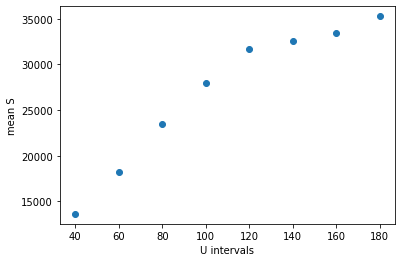

In [14]:
print('lowest U value: ', np.min(unglaette))
print('highest U value: ', np.max(unglaette))
lower_bound = 40
upper_bound = 200
U_intervals = np.linspace(lower_bound, upper_bound, num = 9, endpoint = True)
print(U_intervals)
S_vals = np.zeros([U_intervals.shape[0]-1], np.float32)
S_quantity = np.zeros([U_intervals.shape[0]-1], np.float32)
int_length = (upper_bound - lower_bound)/(S_vals.shape[0])
print(int_length)

for i in range(unglaette.shape[0]):
    index = math.floor((unglaette[i]-lower_bound)/int_length)
    S_vals[index] += whitespaces[i]
    S_quantity[index] += 1
    
for i in range(S_vals.shape[0]):
    S_vals[i] = S_vals[i]/S_quantity[i]

print(S_vals)
print(U_intervals[0:8])
plt.scatter(x = U_intervals[0:8], y = S_vals)
plt.xlabel('U intervals')
plt.ylabel('mean S')
plt.show()

Text(0.5, 1.0, 'D_3')

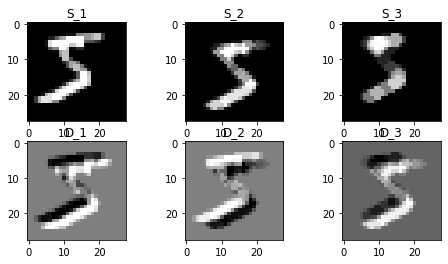

In [29]:
x_ = tf.cast(np.expand_dims((image-127.5)/127.5, 0), tf.float32)
x = tf.Variable(x_)

kernel1 = tf.ones((2,2,1))
kernel2 = np.array([[0,1,0], [1,1,1], [0,1,0]])
kernel2 = np.expand_dims(kernel2, -1)
kernel2 = tf.cast(kernel2, tf.float32)
kernel3 = np.array([[0,1,1,0], [1,1,1,1], [1,1,1,1], [0,1,1,0]])
kernel3 = np.expand_dims(kernel3, -1)
kernel3 = tf.cast(kernel3, tf.float32)
#print(kernel.dtype)
#print(kernel.shape)
#op = opening(x, kernel)
#cl = closing(x, kernel)
#diff = cl-op
S_1 = occo(x, kernel1)
S_2 = occo(x, kernel2)
S_3 = occo(x, kernel3)

D_1 = x - S_1
D_2 = S_1 - S_2
D_3 = S_2 - S_3

_, ax = plt.subplots(2, 3, figsize = (8,4))
ax[0,0].imshow(S_1[0], cmap = 'gray')
ax[0,0].set_title('S_1')
ax[0,1].imshow(S_2[0], cmap = 'gray')
ax[0,1].set_title('S_2')
ax[0,2].imshow(S_3[0], cmap = 'gray')
ax[0,2].set_title('S_3')
ax[1,0].imshow(D_1[0], cmap = 'gray')
ax[1,0].set_title('D_1')
ax[1,1].imshow(D_2[0], cmap = 'gray')
ax[1,1].set_title('D_2')
ax[1,2].imshow(D_3[0], cmap = 'gray')
ax[1,2].set_title('D_3')

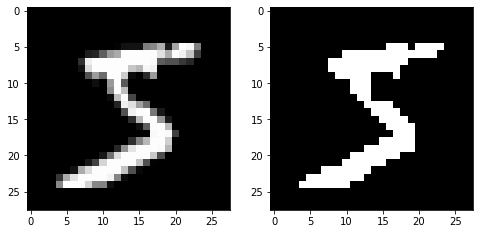

In [30]:
binImage = computeBinaryMap(image)
_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(image, cmap = 'gray')
ax[1].imshow(binImage, cmap = 'gray')

In [31]:
binImage_ = np.expand_dims(np.expand_dims(binImage, 0), -1)
print(binImage_.shape)
u = computeU(binImage_)
print(u)

(1, 28, 28, 1)
tf.Tensor(114, shape=(), dtype=int32)


h1:  tf.Tensor(
[[[[0]]

  [[0]]]], shape=(1, 2, 1, 1), dtype=int32)
v1:  tf.Tensor(
[[[[1]
   [1]]]], shape=(1, 1, 2, 1), dtype=int32)
h2:  tf.Tensor(
[[[[1]]

  [[1]]]], shape=(1, 2, 1, 1), dtype=int32)
v2:  tf.Tensor(
[[[[1]
   [1]]]], shape=(1, 1, 2, 1), dtype=int32)
h3:  tf.Tensor(
[[[[1]]

  [[0]]]], shape=(1, 2, 1, 1), dtype=int32)
v3:  tf.Tensor(
[[[[1]
   [0]]]], shape=(1, 1, 2, 1), dtype=int32)
h4:  tf.Tensor(
[[[[1]]

  [[0]]]], shape=(1, 2, 1, 1), dtype=int32)
v4:  tf.Tensor(
[[[[1]
   [0]]]], shape=(1, 1, 2, 1), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


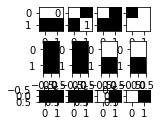

In [32]:
testImg1 = np.array([[1,1],[0,0]], np.int32)
testImg2 = np.array([[1,0],[0,1]], np.int32)
testImg3 = np.array([[1,0],[0,0]], np.int32)
testImg4 = np.array([[0,1],[1,1]], np.int32)

testImg1_ = np.expand_dims(np.expand_dims(testImg1, 0), -1)
testImg2_ = np.expand_dims(np.expand_dims(testImg2, 0), -1)
testImg3_ = np.expand_dims(np.expand_dims(testImg3, 0), -1)
testImg4_ = np.expand_dims(np.expand_dims(testImg4, 0), -1)

kernelh = np.array([[-1,1]], np.int32)
kernelh = np.expand_dims(kernelh, -1)
kernelh = np.expand_dims(kernelh, -1)

kernelv = np.array([[-1],[1]], np.int32)
kernelv = np.expand_dims(kernelv, -1)
kernelv = np.expand_dims(kernelv, -1)

h1 = tf.abs(conv2d(testImg1_, kernelh, strides = (1,1,1,1), padding = 'VALID'))
v1 = tf.abs(conv2d(testImg1_, kernelv, strides = (1,1,1,1), padding = 'VALID'))
h2 = tf.abs(conv2d(testImg2_, kernelh, strides = (1,1,1,1), padding = 'VALID'))
v2 = tf.abs(conv2d(testImg2_, kernelv, strides = (1,1,1,1), padding = 'VALID'))
h3 = tf.abs(conv2d(testImg3_, kernelh, strides = (1,1,1,1), padding = 'VALID'))
v3 = tf.abs(conv2d(testImg3_, kernelv, strides = (1,1,1,1), padding = 'VALID'))
h4 = tf.abs(conv2d(testImg4_, kernelh, strides = (1,1,1,1), padding = 'VALID'))
v4 = tf.abs(conv2d(testImg4_, kernelv, strides = (1,1,1,1), padding = 'VALID'))

print("h1: ", h1)
print("v1: ", v1)
print("h2: ", h2)
print("v2: ", v2)
print("h3: ", h3)
print("v3: ", v3)
print("h4: ", h4)
print("v4: ", v4)

_, ax = plt.subplots(3,4, figsize = (2,2))
ax[0,0].imshow(testImg1, cmap = 'gray')
ax[0,1].imshow(testImg2, cmap = 'gray')
ax[0,2].imshow(testImg3, cmap = 'gray')
ax[0,3].imshow(testImg4, cmap = 'gray')
ax[1,0].imshow(h1[0,:,:,], cmap = 'gray')
ax[1,1].imshow(h2[0,:,:,], cmap = 'gray')
ax[1,2].imshow(h3[0,:,:,], cmap = 'gray')
ax[1,3].imshow(h4[0,:,:,], cmap = 'gray')
ax[2,0].imshow(v1[0,:,:,], cmap = 'gray')
ax[2,1].imshow(v2[0,:,:,], cmap = 'gray')
ax[2,2].imshow(v3[0,:,:,], cmap = 'gray')
ax[2,3].imshow(v4[0,:,:,], cmap = 'gray')

print(computeU(np.expand_dims(np.expand_dims(testImg1, 0), -1)))
print(computeU(np.expand_dims(np.expand_dims(testImg2, 0), -1)))
print(computeU(np.expand_dims(np.expand_dims(testImg3, 0), -1)))
print(computeU(np.expand_dims(np.expand_dims(testImg4, 0), -1)))